In [1]:
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,PorterStemmer
import re
import string
import matplotlib.pyplot as plt

## Places Recommender

#### Reading Data

In [3]:
places = pd.read_csv('../datasets/places_dataset.csv')

In [4]:
places.head()

,city,id,name,rate,kinds,distance,coordinates
0,istanbul,N3236233297,Column of Marcian,3,"historic,monuments_and_memorials,burial_places...",185.407919,"{41.015442, 28.950285}"
1,istanbul,W329094469,Amcazade Külliyesi,1,"museums,cultural,interesting_places,other_museums",245.723456,"{41.015182, 28.951982}"
2,istanbul,W329089871,Aziz Mahmud Hudayi Vakfi Gazanfer Ağa Medreses...,1,"museums,cultural,interesting_places,other_museums",559.777594,"{41.016342, 28.955437}"
3,istanbul,W314677393,Reşat Nuri Sahnesi (Tiyatrosu),1,"cultural,theatres_and_entertainments,interesti...",596.409402,"{41.015846, 28.956236}"
4,istanbul,Q776353,Column of Arcadius,3,"historic,cultural,urban_environment,monuments_...",868.591827,"{41.007801, 28.9431}"


In [6]:
places.describe()

,rate,distance
count,107675.000000,107675.000000
mean,2.155979,61945.503180
std,1.995000,109206.215014
min,1.000000,0.099657
25%,1.000000,3832.815904
50%,1.000000,17568.157101
75%,3.000000,74252.355973
max,7.000000,997251.413754


In [7]:
cities_set = set(places['city'])
cities_list = [c for c in cities_set]
places['city_id'] = places['city'].apply(lambda city: cities_list.index(city))
places['city_id']

0         25
1         25
2         25
3         25
4         25
          ..
107670    23
107671    23
107672    23
107673    23
107674    23
Name: city_id, Length: 107675, dtype: int64

In [8]:
places_features_df = pd.DataFrame(places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

,city_id
Column of Marcian,25
Amcazade Külliyesi,25
Aziz Mahmud Hudayi Vakfi Gazanfer Ağa Medresesi Egitim ve Kultur Merkezi,25
Reşat Nuri Sahnesi (Tiyatrosu),25
Column of Arcadius,25


In [9]:
p_features = set()
places['kinds'].apply(lambda item: [p_features.add(x) for x in str(item).split(',')])
col_names = places_features_df.columns
places_features = extract_features(places['kinds'],p_features)

In [10]:
places_features_df = pd.DataFrame(places_features,columns=p_features)
# places_features_df.insert(loc=0,column='city_id',value=places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

,other_amusement_rides,mints,squares,villas_and_chalet,destroyed_objects,museums_of_science_and_technology,wall_painting,thermal_baths,burial_places,bridges,...,open_air_baths,baths_and_saunas,supermarkets,view_points,mineshafts,biergartens,children_museums,factories,military_museums,alpine_hut
Column of Marcian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amcazade Külliyesi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aziz Mahmud Hudayi Vakfi Gazanfer Ağa Medresesi Egitim ve Kultur Merkezi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Reşat Nuri Sahnesi (Tiyatrosu),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Column of Arcadius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# places_corr_matrix = places_features_df.corr()
max_features = []
low_prior = []
for col in places_features_df.columns:
    col_sum = places_features_df[col].sum()
    if col_sum < 20:
        low_prior.append(col)
    else:
        max_features.append((col,col_sum))
    


In [92]:
important_places_features = pd.DataFrame(max_features) 
important_places_features.columns = ['features','sum']
important_places_features.sort_values(by='sum',ascending=False).head() 

,features,sum
31,interesting_places,107675.0
105,religion,29692.0
92,natural,29556.0
49,architecture,23769.0
87,historic_architecture,20267.0


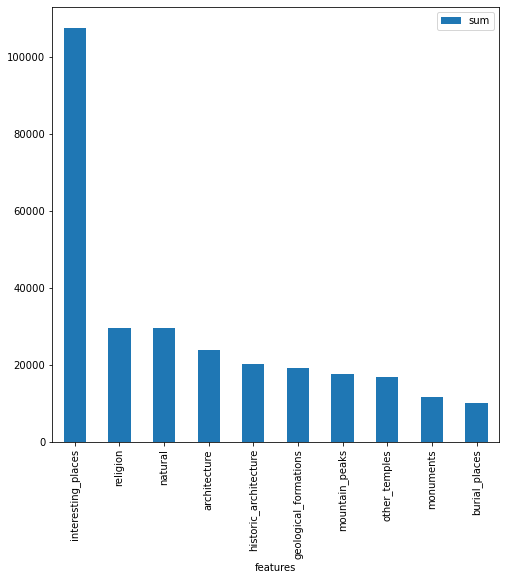

In [94]:
important_places_features.sort_values(by='sum',ascending=False).head(10).plot(kind='bar',x='features',figsize=(8,8))

In [99]:
# sum_features = places_features_df.sum().sort_values(ascending=False)
sum_features = places_features_df.loc[:,(places_features_df.sum() > 20)].sum()
highest_features = places_features_df[sum_features.sort_values(ascending=False).index[:20]]

In [ ]:
ax,fig = plt.subplots(figsize=(10,10))
sns.heatmap(data=highest_features.corr(), cmap=sns.diverging_palette(20, 220, n=200))


In [50]:
p_knn = NearestNeighbors(n_neighbors=20,metric='cosine')
p_knn.fit(places_features_df)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [51]:
p_distances,p_indecies = p_knn.kneighbors(places_features_df)

In [287]:
get_recommendation('Coperto dei Figini',p_indecies,p_distances,places_features_df,places)

Phra Ratcha Wang Bowon Sathan Phimuk : 0.0
Dar Al Makhzen : 0.0
Thewawes Post Office : 0.0
Palácio da Calçada de Santana : 0.0
Palácio Albergaria : 0.0
Palais Schwerin : 0.0
Bang Leng Palace : 0.0
วังจันทรเกษม : 0.0
palais des ducs de Savoie : 0.0
Palau Episcopal : 0.0
Palácio Caldas : 0.0
Palácio dos Condes dos Arcos : 0.0
Palacio Maldá : 0.0
วังสะพานขาว : 0.0
วังจักรพงษ์ : 0.0
Ateneu Comercial de Lisboa : 0.0
El Glaoui Palace, Fez : 0.0
Phra Racha Wang Derm : 0.0
Ladawan palace : 0.0


In [293]:
similarity('Palau Episcopal','Phra Racha Wang Derm',places_features_df) 


1.0

In [52]:
tsne_p = TSNE().fit_transform(p_indecies[:1000])

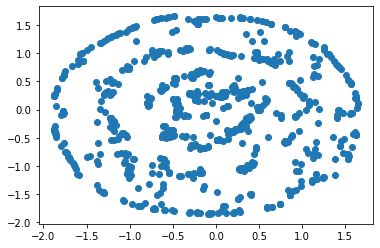

In [53]:
plt.scatter(tsne_p[:,0],tsne_p[:,1])

In [ ]:
## Places Recommender

#### Reading Data

places = pd.read_csv('datasets/places_dataset.csv')

places.head()

places.describe()

cities_set = set(places['city'])
cities_list = [c for c in cities_set]
places['city_id'] = places['city'].apply(lambda city: cities_list.index(city))
places['city_id']

places_features_df = pd.DataFrame(places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

p_features = set()
places['kinds'].apply(lambda item: [p_features.add(x) for x in str(item).split(',')])
col_names = places_features_df.columns
places_features = extract_features(places['kinds'],p_features)

places_features_df = pd.DataFrame(places_features,columns=p_features)
# places_features_df.insert(loc=0,column='city_id',value=places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

# places_corr_matrix = places_features_df.corr()
max_features = []
low_prior = []
for col in places_features_df.columns:
    col_sum = places_features_df[col].sum()
    if col_sum < 20:
        low_prior.append(col)
    else:
        max_features.append((col,col_sum))
    


important_places_features = pd.DataFrame(max_features) 
important_places_features.columns = ['features','sum']
important_places_features.sort_values(by='sum',ascending=False).head() 

important_places_features.sort_values(by='sum',ascending=False).head(10).plot(kind='bar',x='features',figsize=(8,8))

# sum_features = places_features_df.sum().sort_values(ascending=False)
sum_features = places_features_df.loc[:,(places_features_df.sum() > 20)].sum()
highest_features = places_features_df[sum_features.sort_values(ascending=False).index[:20]]

ax,fig = plt.subplots(figsize=(10,10))
sns.heatmap(data=highest_features.corr(), cmap=sns.diverging_palette(20, 220, n=200))


p_knn = NearestNeighbors(n_neighbors=20,metric='cosine')
p_knn.fit(places_features_df)

p_distances,p_indecies = p_knn.kneighbors(places_features_df)

get_recommendation('Coperto dei Figini',p_indecies,p_distances,places_features_df,places)

similarity('Palau Episcopal','Phra Racha Wang Derm',places_features_df) 


tsne_p = TSNE().fit_transform(p_indecies[:1000])

plt.scatter(tsne_p[:,0],tsne_p[:,1])